In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to your folder (replace with your actual folder path)
folder_path = '/content/drive/My Drive/split_dataset'

# List files in the folder
os.listdir(folder_path)

['images', 'split_dataset', 'labels', '__MACOSX']

In [ ]:
def load_image_and_label(image_path, label_path, image_size=(224, 224)):
    # The input image_path and label_path are expected to be bytes objects
    # when coming from tf.numpy_function with string tensors.
    # We need to decode them before using with Python/OpenCV functions.
    image_path_str = image_path.decode('utf-8')
    label_path_str = label_path.decode('utf-8')

    image_size_int = (int(image_size[0]), int(image_size[1]))

    # Load RGB image and resize
    img = cv2.imread(image_path_str)
    if img is None:
        print(f"Warning: Could not read image file: {image_path_str}")
        # Return zero-filled arrays or handle the error appropriately
        return np.zeros((image_size_int[0], image_size_int[1], 1), dtype=np.float32), np.zeros(num_classes, dtype=np.float32)

    img = cv2.resize(img, image_size_int)
    img = cv2.medianBlur(img, 5)
    img = img.astype(np.float32) / 255.0  # Normalize

    # Grayscale + high-pass filter
    img_gray = cv2.imread(image_path_str, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
         print(f"Warning: Could not read image file for grayscale: {image_path_str}")
         return np.zeros((image_size_int[0], image_size_int[1], 1), dtype=np.float32), np.zeros(num_classes, dtype=np.float32)

    img_gray = cv2.resize(img_gray, image_size_int)
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]])
    high_pass = cv2.filter2D(img_gray, -1, kernel)
    high_pass = high_pass.astype(np.float32) / 255.0

    # Load class ID from label
    try:
        with open(label_path_str, 'r') as file:
            line = file.readline().strip()
            class_id = int(line.split()[0]) if line else 0
    except FileNotFoundError:
        print(f"Warning: Label file not found for image: {image_path_str}")
        return np.zeros((image_size_int[0], image_size_int[1], 1), dtype=np.float32), np.zeros(num_classes, dtype=np.float32)
    except Exception as e:
        print(f"Error reading label file {label_path_str}: {e}")
        return np.zeros((image_size_int[0], image_size_int[1], 1), dtype=np.float32), np.zeros(num_classes, dtype=np.float32)


    label_vector = np.zeros(num_classes, dtype=np.float32)
    if 0 <= class_id < num_classes:
        label_vector[class_id] = 1.0
    else:
        print(f"Warning: Invalid class ID {class_id} in {label_path_str}")
        # Return zero-filled label or handle appropriately
        pass # keep label_vector as zeros

    # We need to return a 3-channel image for compatibility with potential future models
    # or ensure the model input layer is 1-channel. The current model is 1-channel.
    return high_pass[..., np.newaxis], label_vector

In [ ]:
def tf_load_image_and_label(img_path, lbl_path, image_size):
    # tf.numpy_function will convert the string tensors to bytes objects
    # when passing them to the Python function.
    def _load(img_path_np, lbl_path_np):
        # img_path_np and lbl_path_np are bytes objects here
        return load_image_and_label(img_path_np, lbl_path_np, image_size)

    img, label = tf.numpy_function(
        _load, [img_path, lbl_path], [tf.float32, tf.float32]
    )
    img.set_shape((image_size[0], image_size[1], 1))
    label.set_shape((num_classes,))
    return img, label

In [ ]:
def create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train', show_warnings=True):
    sub_image_dir = os.path.join(image_dir, dataset_type)
    sub_label_dir = os.path.join(label_dir, dataset_type)

    # Check if directories exist
    if not os.path.exists(sub_image_dir):
        if show_warnings:
            print(f"Warning: Image directory not found: {sub_image_dir}")
        return tf.data.Dataset.from_tensor_slices(())
    if not os.path.exists(sub_label_dir):
        if show_warnings:
            print(f"Warning: Label directory not found: {sub_label_dir}")
        return tf.data.Dataset.from_tensor_slices(())

    try:
        image_paths = [f for f in os.listdir(sub_image_dir) if f.lower().endswith(('.jpg', '.png'))]
    except OSError as e:
        if show_warnings:
            print(f"Error listing image directory {sub_image_dir}: {e}")
        return tf.data.Dataset.from_tensor_slices(())


    image_file_paths = []
    label_file_paths = []

    for image_name in image_paths:
        base_name = os.path.splitext(image_name)[0]
        label_name = base_name + '.txt'
        label_path = os.path.join(sub_label_dir, label_name)

        image_path = os.path.join(sub_image_dir, image_name)

        if os.path.exists(label_path) and os.path.exists(image_path):
            image_file_paths.append(image_path)
            label_file_paths.append(label_path)
        else:
            if show_warnings:
                if not os.path.exists(image_path):
                     print(f"Warning: Image file not found: {image_path}")
                if not os.path.exists(label_path):
                    print(f"Warning: Missing label file for image: {image_name} at {label_path}")


    if not image_file_paths:
        if show_warnings:
            print(f"Warning: No valid image-label pairs found in {sub_image_dir}")
        return tf.data.Dataset.from_tensor_slices(())

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(
        lambda img_path, lbl_path: tf_load_image_and_label(img_path, lbl_path, image_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if dataset_type == 'train':
        # Shuffle the dataset
        dataset = dataset.shuffle(buffer_size=len(image_file_paths))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
num_classes = 2

model = Sequential([
    Input(shape=(224, 224, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
image_dir = '/content/drive/My Drive/split_dataset/images'
label_dir = '/content/drive/My Drive/split_dataset/labels'

train_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train')
val_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='val')
test_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='test')

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check if datasets are empty before fitting
if train_dataset is not None and tf.data.experimental.cardinality(train_dataset).numpy() > 0:
    history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.6642 - loss: 0.7499 - val_accuracy: 0.8590 - val_loss: 0.2575
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 110s 293ms/step - accuracy: 0.9049 - loss: 0.2185 - val_accuracy: 0.9103 - val_loss: 0.1956
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.9601 - loss: 0.1384 - val_accuracy: 0.9915 - val_loss: 0.0296
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 292ms/step - accuracy: 0.9807 - loss: 0.0619 - val_accuracy: 0.9915 - val_loss: 0.0311
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 293ms/step - accuracy: 0.9857 - loss: 0.0444 - val_accuracy: 0.9915 - val_loss: 0.0195
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 293ms/step - accuracy: 0.9880 - loss: 0.0411 - val_accuracy: 0.9915 - val_loss: 0.0231
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0.9946 - loss: 0.0275 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 195ms/step - accuracy: 0.9944 - loss: 0.0172 - val_accur

In [ ]:
# Access loss and accuracy history
train_loss = history.history['loss']  # List of training loss values per epoch
train_accuracy = history.history['accuracy']  # List of training accuracy values per epoch
val_loss = history.history['val_loss']  # List of validation loss values per epoch
val_accuracy = history.history['val_accuracy']  # List of validation accuracy values per epoch

# Print the final values of loss and accuracy for the last epoch
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Final Training Loss: 0.011584494262933731
Final Training Accuracy: 0.9969947338104248
Final Validation Loss: 0.0061101606115698814
Final Validation Accuracy: 1.0


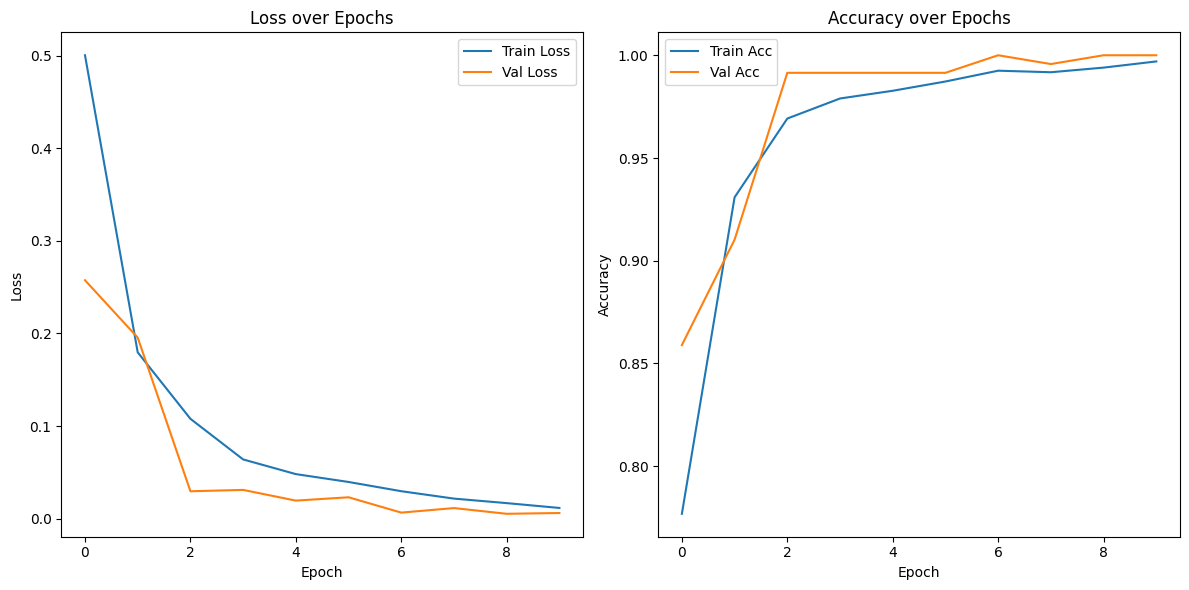

In [ ]:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Acc')
    plt.plot(val_accuracy, label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - accuracy: 0.9915 - loss: 0.0170
Test Loss: 0.0179887767881155
Test Accuracy: 0.9915966391563416
